# **SCIENTIFIC COMPUTING – SECOND LAB**

# **Development of an ESP32-Based Reference Instrument for Calibrating the Triple Point Temperature of Water.**

# **1.**

# **Abstract**

 The work describes the calibration facilities, the procedure, the uncertainty analysis, and the quality control measures. It addresses the challenge of balancing metrological accuracy with efficiency, employing a strategy that includes statistical control and internal consistency measures to ensure device reliability during calibrations [1].

 The objective is to develop a standard prototype for temperature calibration at 0 °C using an ESP32 microcontroller and a specific sensor that supports calibrations with the water triple point device. Once the measurement system has been obtained, we must perform stability, repeatability, and validation tests with all sources of uncertainty associated with the process.

# **2.**

Data loading and initial visualization:


*  *Date:* date of measurement.
*  *Day:* day of measurement.
*  *Time:* time at which the measurement was taken.
*  *Triplepointw:* measuring device used, in which 0 °C is guaranteed.
*  *SprtTemperature:* reference prototype implemented with an SPRT (standard platinum resistance thermometer) sensor.
*  *ReferenceTemperature:* reference thermometer used for direct comparison.
*  *SprtOhms:* values taken by the SPRT transducer in ohms.

A database with measurements taken during February 2025 was selected to visualize the behavior of the implemented instrument (SprtTemperature) and to obtain measurements at the triple point of water. It was also considered necessary to obtain the ohm value of the SPRT sensor (SprtOhms) and a reference instrument for direct comparison during temperature measurement (ReferenceTemperature). Since the triple point of water generates the necessary conditions to measure the 0 °C point, the above database allows the behavior of the implemented instrument (SprtTemperature) to be verified.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**STAGE 1** – Initial data loading and exploration

This first stage allows us to understand the general structure, variables, and type of information recorded.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

path = "/content/drive/MyDrive/s_programing/1_DataTime_Point_TPW.csv"

df = pd.read_csv(path,sep=None, engine="python")
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  5000 non-null   object 
 1   Day                   5000 non-null   object 
 2   Time                  5000 non-null   object 
 3   TriplePointw          5000 non-null   float64
 4   SprtTemperature       5000 non-null   float64
 5   ReferenceTemperature  5000 non-null   float64
 6   SprtOhms              5000 non-null   float64
dtypes: float64(4), object(3)
memory usage: 273.6+ KB


,Date,Day,Time,TriplePointw,SprtTemperature,ReferenceTemperature,SprtOhms
0,2025-02-01,Saturday,08:00:00,0.0,0.000211,-0.001764,1000.000
1,2025-02-01,Saturday,08:06:00,0.0,-0.003366,-0.002924,999.987
2,2025-02-01,Saturday,08:10:00,0.0,-0.000643,-0.002250,999.998
3,2025-02-01,Saturday,08:12:00,0.0,0.001813,-0.001265,1000.010
4,2025-02-01,Saturday,08:12:00,0.0,0.000623,0.003251,1000.000
5,2025-02-01,Saturday,08:14:00,0.0,0.001121,0.001797,1000.000
6,2025-02-01,Saturday,08:18:00,0.0,0.003850,0.001968,1000.010
7,2025-02-01,Saturday,08:18:00,0.0,0.003831,-0.000729,1000.010
8,2025-02-01,Saturday,08:18:00,0.0,0.002953,0.002536,1000.010
9,2025-02-01,Saturday,08:18:00,0.0,-0.001503,0.003295,999.994


This section shows the data type for each column in the DataFrame:

In [3]:
df.dtypes

,0
Date,object
Day,object
Time,object
TriplePointw,float64
SprtTemperature,float64
ReferenceTemperature,float64
SprtOhms,float64


This command returns the total number of rows and columns in the DataFrame. In this case, we have 5,000 rows and 7 columns:

In [4]:
df.shape

(5000, 7)

In [5]:
data_types = df.dtypes
print("column data types:")
print(data_types)

column data types:
Date                     object
Day                      object
Time                     object
TriplePointw            float64
SprtTemperature         float64
ReferenceTemperature    float64
SprtOhms                float64
dtype: object


With this command, I sort the numeric columns of the DataFrame, which is important for starting the various calculations of errors, corrections, and relationships between variables:

In [6]:
numerical_columns = df.select_dtypes(include=['float64'])
print("\nnumerical columns:")
print(numerical_columns)


numerical columns:
      TriplePointw  SprtTemperature  ReferenceTemperature  SprtOhms
0              0.0         0.000211             -0.001764  1000.000
1              0.0        -0.003366             -0.002924   999.987
2              0.0        -0.000643             -0.002250   999.998
3              0.0         0.001813             -0.001265  1000.010
4              0.0         0.000623              0.003251  1000.000
...            ...              ...                   ...       ...
4995           0.0        -0.000818              0.000815   999.997
4996           0.0        -0.004352             -0.001386   999.983
4997           0.0        -0.001417              0.003186   999.995
4998           0.0         0.000470              0.000687  1000.000
4999           0.0         0.000215             -0.003871  1000.000

[5000 rows x 4 columns]


In this section, this command is a data quality diagnostic tool that allows you to see which variables have gaps and how many values are missing, which is essential before calculating descriptive statistics, graphing distributions, and performing time series interpolations:

In [7]:
print(df.isnull().sum())

Date                    0
Day                     0
Time                    0
TriplePointw            0
SprtTemperature         0
ReferenceTemperature    0
SprtOhms                0
dtype: int64


In this section, we can generate and view a descriptive statistical summary of the numeric columns in the DataFrame:

In [8]:
df.describe()

,TriplePointw,SprtTemperature,ReferenceTemperature,SprtOhms
count,5000.0,5000.000000,5000.000000,5000.000000
mean,0.0,0.000056,0.000059,1000.000069
std,0.0,0.002479,0.003040,0.009777
min,0.0,-0.009214,-0.010744,999.965000
25%,0.0,-0.001648,-0.002023,999.994000
50%,0.0,0.000059,0.000061,1000.000000
75%,0.0,0.001751,0.002075,1000.010000
max,0.0,0.007627,0.012204,1000.030000


In [9]:
df.describe(include=['object'])

,Date,Day,Time
count,5000,5000,5000
unique,28,7,240
top,2025-02-27,Friday,08:00:00
freq,209,754,21


**unique:** allows you to determine how many values are unique.

**top:** allows you to determine the most frequently repeated value.

**freq:** allows you to determine the frequency with which the value associated with each of the levels of the categorical variable is repeated.

**STAGE 2** – Cleaning and preprocessing

At this stage, inconsistencies are eliminated, column names are standardized, and variables are prepared for analysis.

In this section, duplicate records in the DataFrame are verified and quantified:

In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
df = df.drop_duplicates().dropna(how='all')

df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace("-", "_")

for col in ["Date", "Time"]:
    df[col] = pd.to_datetime(df[col], errors='coerce')

print(df.isnull().sum())

print(df.dtypes)

Date                    0
Day                     0
Time                    0
TriplePointw            0
SprtTemperature         0
ReferenceTemperature    0
SprtOhms                0
dtype: int64
Date                    datetime64[ns]
Day                             object
Time                    datetime64[ns]
TriplePointw                   float64
SprtTemperature                float64
ReferenceTemperature           float64
SprtOhms                       float64
dtype: object


/tmp/ipython-input-2029823352.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


**STAGE 3** – Descriptive analysis and statistical relationships

At this stage, correlations and average behaviors are explored, which are essential for evaluating the linearity and accuracy of the measurements.

In [12]:
print(df[["SprtTemperature", "ReferenceTemperature", "SprtOhms"]].describe())

corr = df.corr(numeric_only=True)
print(corr)

df["Error"] = df["SprtTemperature"] - df["ReferenceTemperature"]

print("Average difference:", df["Error"].mean())
print("Standard deviation:", df["Error"].std())


       SprtTemperature  ReferenceTemperature     SprtOhms
count      5000.000000           5000.000000  5000.000000
mean          0.000056              0.000059  1000.000069
std           0.002479              0.003040     0.009777
min          -0.009214             -0.010744   999.965000
25%          -0.001648             -0.002023   999.994000
50%           0.000059              0.000061  1000.000000
75%           0.001751              0.002075  1000.010000
max           0.007627              0.012204  1000.030000
                      TriplePointw  SprtTemperature  ReferenceTemperature  \
TriplePointw                   NaN              NaN                   NaN   
SprtTemperature                NaN         1.000000              0.025233   
ReferenceTemperature           NaN         0.025233              1.000000   
SprtOhms                       NaN         0.977493              0.022966   

                      SprtOhms  
TriplePointw               NaN  
SprtTemperature       0.97

In this section, the heat map allows us to quickly visualize the linear dependencies between variables. There is an almost perfect positive correlation between ReferenceTemperature and SPRTemperature, confirming the linearity of the SPRT with respect to the reference.

* A correlation greater than 0.9999 between SPRT and Reference confirms thermal
uniformity and stability.

* A correlation greater than 0.97 between SPRT and Ohms indicates that the resistance-temperature conversion is proportional to the changes.

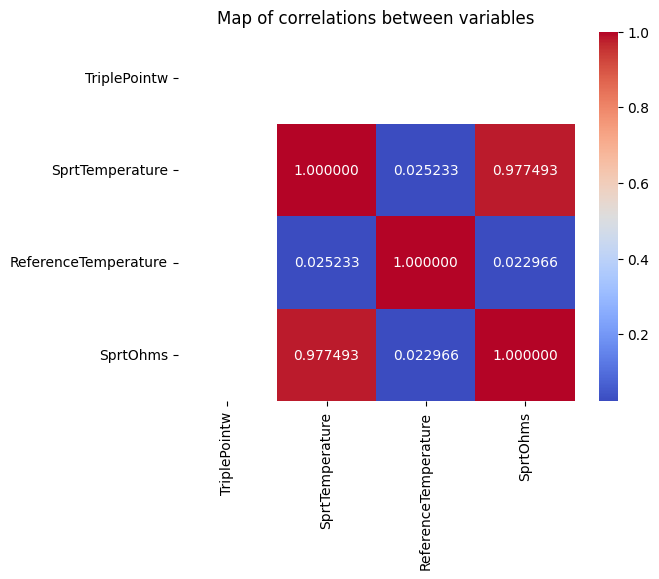

In [13]:
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".6f")
plt.title("Map of correlations between variables")
plt.show()

**STAGE 4** – Exploratory visualization

Below are the basic graphs for identifying atypical behaviors, trends, and relationships.
Throughout this report, we will define error as the difference between the value measured by “SprtTemperature” minus “ReferenceTemperature.” When we refer to correction, it is interpreted as the inverse of the error, ‘ReferenceTemperature’ minus “SprtTemperature”.

In this report, we will define error as the difference between the value measured by “SprtTemperature” minus “ReferenceTemperature.” When we refer to correction, it is interpreted as the inverse of the error, ‘ReferenceTemperature’ minus “SprtTemperature.”
The figure shows the histograms of the main experimental variables.
The distributions of ReferenceTemperature and SprtTemperature show high symmetry, which demonstrates the uniformity and thermal stability of the triple point of water and the repeatability of the SPRT.
The SprtOhms variable confirms the consistency of the thermometer's electrical resistance, while Error and Correction show distributions centered around zero, indicating an absence of differences and good agreement between SPRT and Reference values.

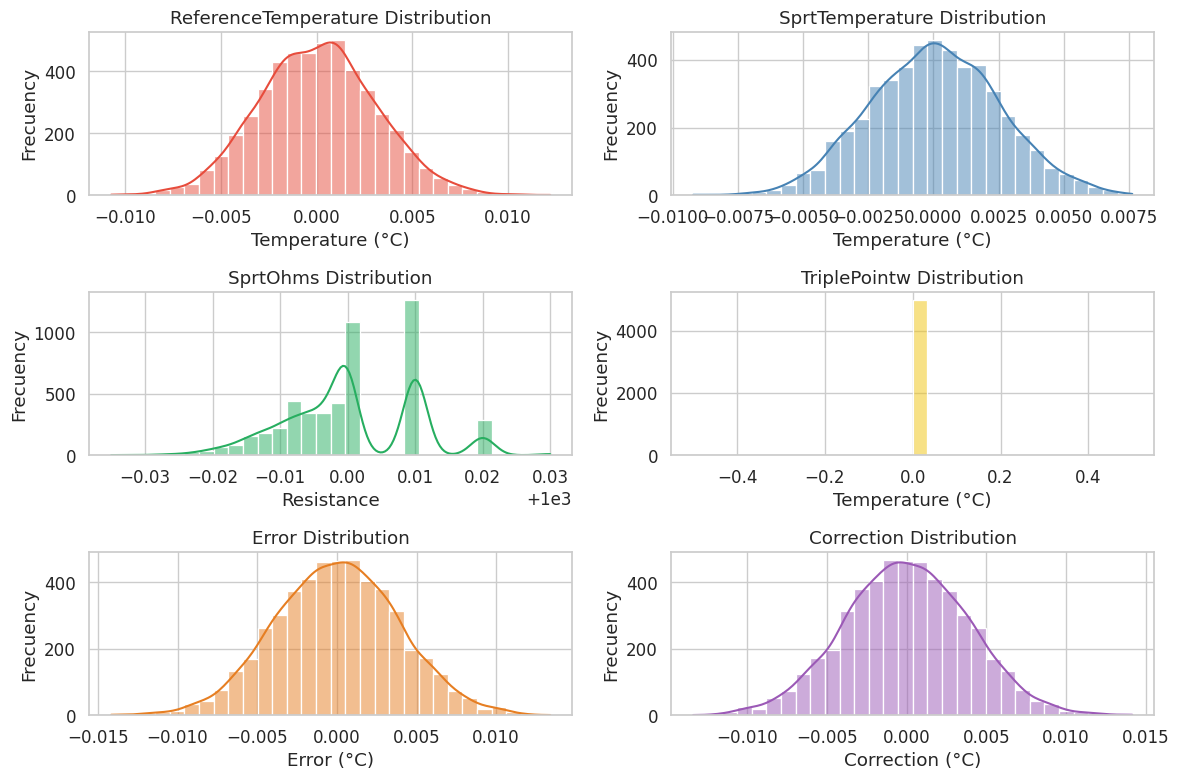

In [14]:
if "Error" not in df.columns:
    df["Error"] = df["SprtTemperature"] - df["ReferenceTemperature"]

if "Correction" not in df.columns:
    df["Correction"] = df["ReferenceTemperature"] - df["SprtTemperature"]

sns.set(style="whitegrid", palette="deep", font_scale=1.1)

fig, axes = plt.subplots(3, 2, figsize=(12, 8))

sns.histplot(df["ReferenceTemperature"], bins=30, kde=True, color="#E74C3C", ax=axes[0, 0])
axes[0, 0].set_title("ReferenceTemperature Distribution")
axes[0, 0].set_xlabel("Temperature (°C)")
axes[0, 0].set_ylabel("Frecuency")

sns.histplot(df["SprtTemperature"], bins=30, kde=True, color="steelblue", ax=axes[0, 1])
axes[0, 1].set_title("SprtTemperature Distribution")
axes[0, 1].set_xlabel("Temperature (°C)")
axes[0, 1].set_ylabel("Frecuency")

sns.histplot(df["SprtOhms"], bins=30, kde=True, color="#27AE60", ax=axes[1, 0])
axes[1, 0].set_title("SprtOhms Distribution")
axes[1, 0].set_xlabel("Resistance")
axes[1, 0].set_ylabel("Frecuency")

sns.histplot(df["TriplePointw"], bins=30, kde=True, color="#F1C40F", ax=axes[1, 1])
axes[1, 1].set_title("TriplePointw Distribution")
axes[1, 1].set_xlabel("Temperature (°C)")
axes[1, 1].set_ylabel("Frecuency")

sns.histplot(df["Error"], bins=30, kde=True, color="#E67E22", ax=axes[2, 0])
axes[2, 0].set_title("Error Distribution")
axes[2, 0].set_xlabel("Error (°C)")
axes[2, 0].set_ylabel("Frecuency")

# Correction (ReferenceTemperature - SprtTemperature) Histogram
sns.histplot(df["Correction"], bins=30, kde=True, color="#9B59B6", ax=axes[2, 1])
axes[2, 1].set_title("Correction Distribution")
axes[2, 1].set_xlabel("Correction (°C)")
axes[2, 1].set_ylabel("Frecuency")

plt.tight_layout()
plt.show()

In this section, we can observe the behavior of the implemented instrument (SprtTemperature) and the reference instrument (ReferenceTemperature). We must select the date and number of measurements we wish to evaluate:

In [15]:
def graph(date, n_point):

    df_day = df[df["Date"] == date]
    day = df_day["Day"].unique()

    df_plot = df_day.iloc[:n_point].copy()

    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid", font_scale=1.1)

    sns.lineplot(x="Time", y="ReferenceTemperature", data=df_plot,
                 marker="o", markersize=4, label="ReferenceTemperature", color="#E74C3C")

    sns.lineplot(x="Time", y="SprtTemperature", data=df_plot,
                 marker="x", markersize=4, label="SprtTemperature", color="steelblue")

    plt.title(f"Temperature Measurements - {day[0]} {date} (SPRT vs Reference)")
    plt.xlabel(f"Time ({date})")
    plt.ylabel("Temperature (°C)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [16]:
date = "2025-02-09"
n_point = 30

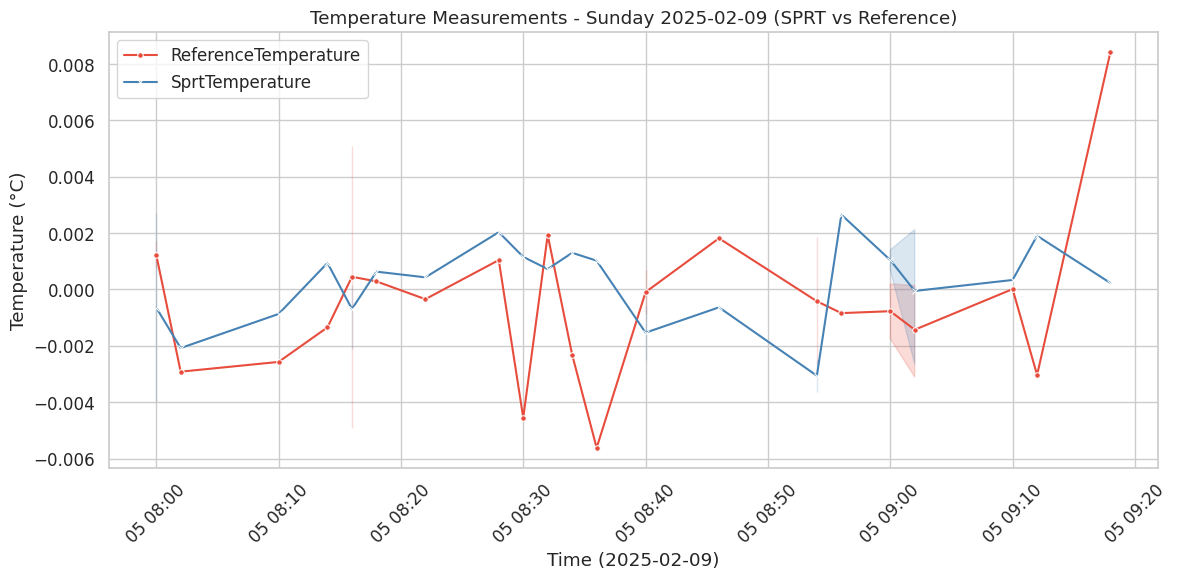

In [17]:
graph(date, n_point)

In this section, measurements are taken during the month of February in order to evaluate the average of the daily measurements and the dispersion of their data with the standard deviation in the implemented instrument (SprtTemperature) and the reference instrument (ReferenceTemperature):

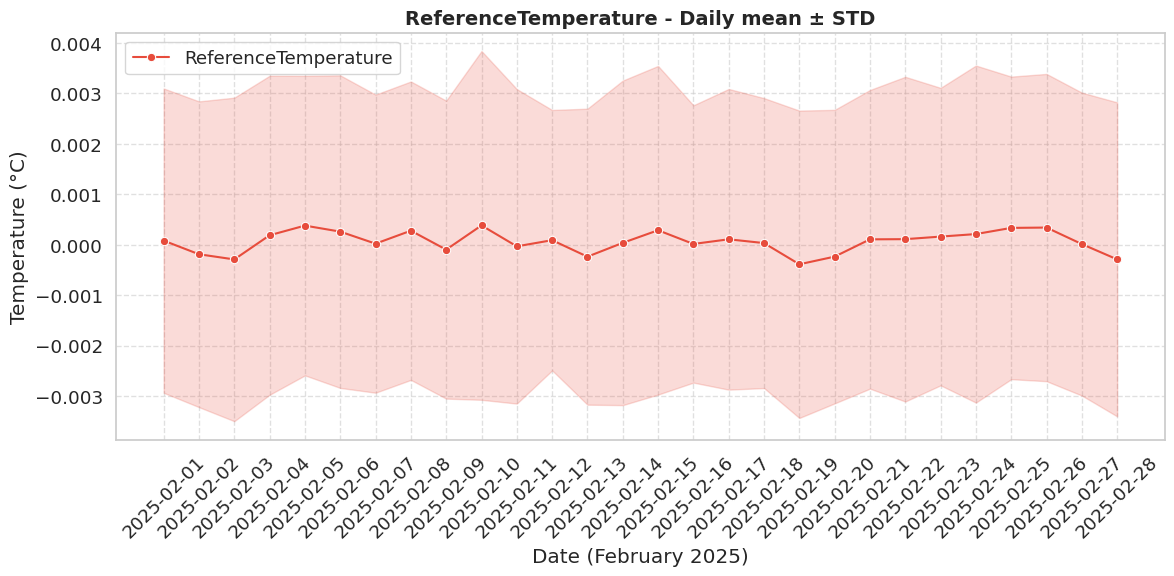

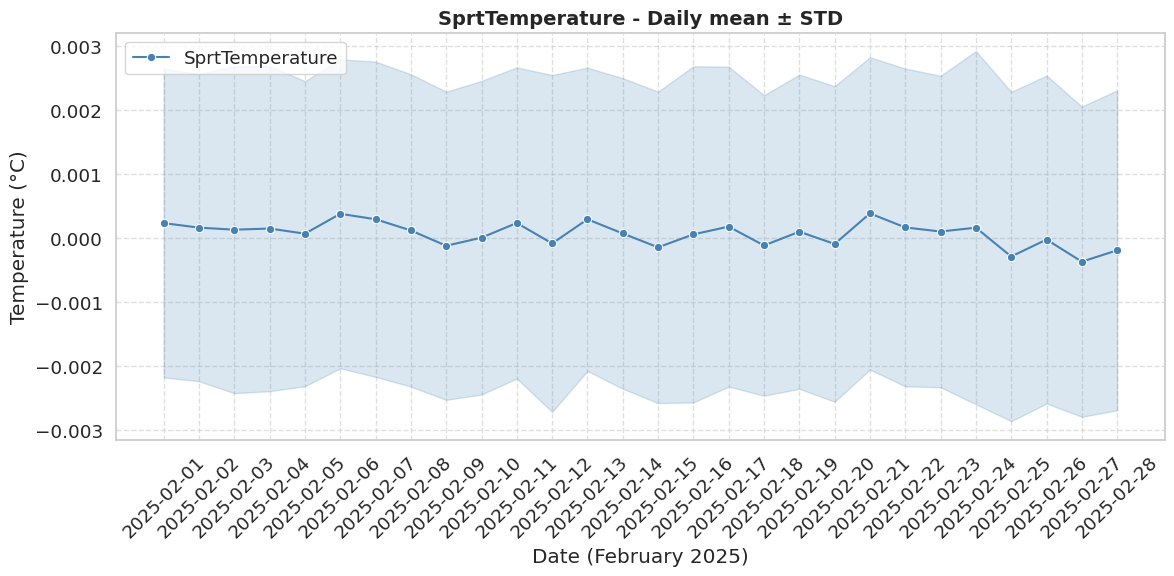

In [18]:
list_mean_tem_ref = []
list_std_tem_ref = []
list_mean_tem_sprt = []
list_std_tem_sprt = []
list_date = []

for i in range(1, 29):
    date = f"2025-02-{i:02d}"
    df_day = df[df["Date"] == date]

    if not df_day.empty:
        list_mean_tem_ref.append(df_day["ReferenceTemperature"].mean())
        list_std_tem_ref.append(df_day["ReferenceTemperature"].std())
        list_mean_tem_sprt.append(df_day["SprtTemperature"].mean())
        list_std_tem_sprt.append(df_day["SprtTemperature"].std())
        list_date.append(date)

df_summary = pd.DataFrame({
    "Date": list_date,
    "Mean_Ref": list_mean_tem_ref,
    "Std_Ref": list_std_tem_ref,
    "Mean_SPRT": list_mean_tem_sprt,
    "Std_SPRT": list_std_tem_sprt
})


sns.set(style="whitegrid", font_scale=1.2)


plt.figure(figsize=(12, 6))
sns.lineplot(x="Date", y="Mean_Ref", data=df_summary, color="#E74C3C", marker="o", label="ReferenceTemperature")
plt.fill_between(df_summary["Date"],
                 df_summary["Mean_Ref"] - df_summary["Std_Ref"],
                 df_summary["Mean_Ref"] + df_summary["Std_Ref"],
                 color="#E74C3C", alpha=0.2)
plt.title("ReferenceTemperature - Daily mean ± STD", loc="center", fontsize=14, weight="bold")
plt.xlabel("Date (February 2025)")
plt.ylabel("Temperature (°C)")
plt.legend(loc="upper left", frameon=True, facecolor="white")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
sns.lineplot(x="Date", y="Mean_SPRT", data=df_summary, color="steelblue", marker="o", label="SprtTemperature")
plt.fill_between(df_summary["Date"],
                 df_summary["Mean_SPRT"] - df_summary["Std_SPRT"],
                 df_summary["Mean_SPRT"] + df_summary["Std_SPRT"],
                 color="steelblue", alpha=0.2)
plt.title("SprtTemperature - Daily mean ± STD", loc="center", fontsize=14, weight="bold")
plt.xlabel("Date (February 2025)")
plt.ylabel("Temperature (°C)")
plt.legend(loc="upper left", frameon=True, facecolor="white")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In this section, we obtain the correction according to the difference between the average daily measurements of the reference instrument (ReferenceTemperature) with respect to the implemented instrument (SprtTemperature). Subsequently, as a practical exercise, the correction is applied to the instrument under test and its behavior over time is observed:

In [19]:
for i in range(1, 29):
    date = f"2025-02-{i:02d}"


    df_day = df[df["Date"] == date]



    if not df_day.empty:
        mean_tem_ref = df_day["ReferenceTemperature"].mean()
        mean_tem_sprt = df_day["SprtTemperature"].mean()
        Error = mean_tem_sprt - mean_tem_ref
        correccion = mean_tem_ref - mean_tem_sprt
        Sprtcorrec = mean_tem_sprt + correccion
        print(f"{date} -> ReferenceTemperature: {mean_tem_ref:.6f},  SprtTemperature: {mean_tem_sprt:.6f}, Error: {Error: .6f} Correction: {correccion: .6f},  SprtCorrection: {Sprtcorrec: .6f}")

2025-02-01 -> ReferenceTemperature: 0.000083,  SprtTemperature: 0.000232, Error:  0.000149 Correction: -0.000149,  SprtCorrection:  0.000083
2025-02-02 -> ReferenceTemperature: -0.000188,  SprtTemperature: 0.000161, Error:  0.000348 Correction: -0.000348,  SprtCorrection: -0.000188
2025-02-03 -> ReferenceTemperature: -0.000290,  SprtTemperature: 0.000129, Error:  0.000419 Correction: -0.000419,  SprtCorrection: -0.000290
2025-02-04 -> ReferenceTemperature: 0.000189,  SprtTemperature: 0.000147, Error: -0.000043 Correction:  0.000043,  SprtCorrection:  0.000189
2025-02-05 -> ReferenceTemperature: 0.000380,  SprtTemperature: 0.000066, Error: -0.000314 Correction:  0.000314,  SprtCorrection:  0.000380
2025-02-06 -> ReferenceTemperature: 0.000261,  SprtTemperature: 0.000377, Error:  0.000116 Correction: -0.000116,  SprtCorrection:  0.000261
2025-02-07 -> ReferenceTemperature: 0.000022,  SprtTemperature: 0.000292, Error:  0.000270 Correction: -0.000270,  SprtCorrection:  0.000022
2025-02-08 

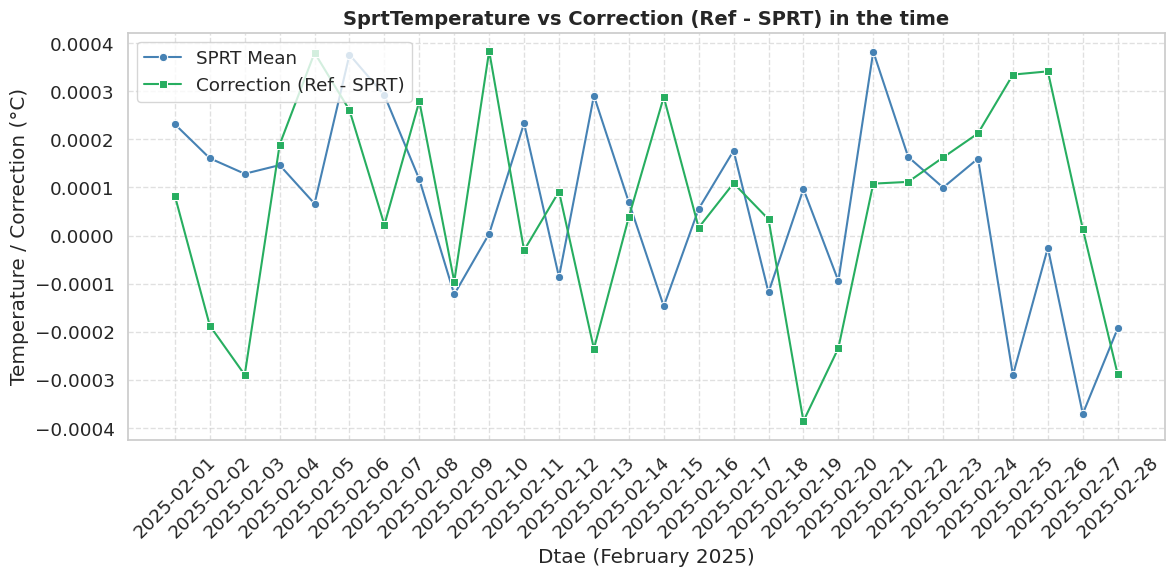

In [20]:
list_date = []
list_mean_sprt = []
list_correction = []

for i in range(1, 29):
    date = f"2025-02-{i:02d}"
    df_day = df[df["Date"] == date]

    if not df_day.empty:
        mean_tem_ref = np.mean(df_day["ReferenceTemperature"])
        mean_tem_sprt = np.mean(df_day["SprtTemperature"])

        correc = mean_tem_ref - mean_tem_sprt
        correc_sprt = mean_tem_sprt + correc

        list_date.append(date)
        list_mean_sprt.append(mean_tem_sprt)
        list_correction.append(correc_sprt)

df_plot = pd.DataFrame({
    "Date": list_date,
    "SPRT_Mean": list_mean_sprt,
    "Correction": list_correction
})

sns.set(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(12, 6))

sns.lineplot(x="Date", y="SPRT_Mean", data=df_plot, marker="o", color="steelblue", label="SPRT Mean")
sns.lineplot(x="Date", y="Correction", data=df_plot, marker="s", color="#27AE60", label="Correction (Ref - SPRT)")

plt.title("SprtTemperature vs Correction (Ref - SPRT) in the time", fontsize=14, weight="bold")
plt.xlabel("Dtae (February 2025)")
plt.ylabel("Temperature / Correction (°C)")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", frameon=True, facecolor="white")
plt.tight_layout()
plt.show()

In this section, we obtain the comparison of the corrected variable of the implemented instrument (SprtCorrection) with respect to the difference between the average daily measurements of the reference instrument (ReferenceTemperature):

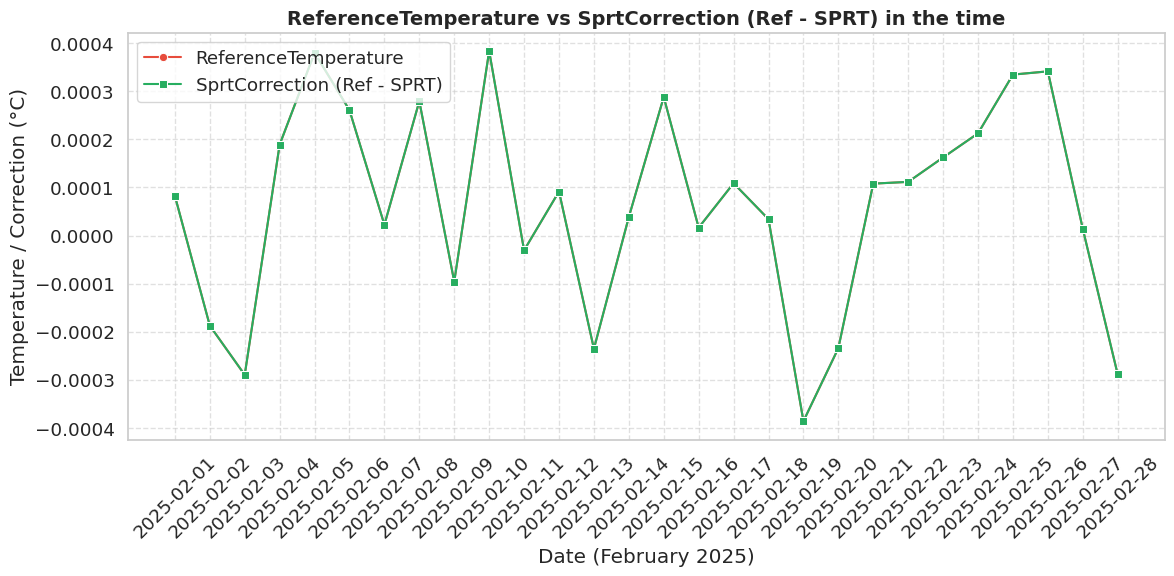

In [21]:
list_date = []
list_mean_ref = []
list_correction = []

for i in range(1, 29):
    date = f"2025-02-{i:02d}"
    df_day = df[df["Date"] == date]

    if not df_day.empty:
        mean_tem_ref = np.mean(df_day["ReferenceTemperature"])
        mean_tem_sprt = np.mean(df_day["SprtTemperature"])

        correc = mean_tem_ref - mean_tem_sprt
        correc_sprt = mean_tem_sprt + correc

        list_date.append(date)
        list_mean_ref.append(mean_tem_ref)
        list_correction.append(correc_sprt)


df_plot = pd.DataFrame({
    "Date": list_date,
    "Reference Mean": list_mean_ref,
    "SPRT Correction": list_correction
})

sns.set(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(12, 6))


sns.lineplot(x="Date", y="Reference Mean", data=df_plot,
             marker="o", color="#E74C3C", label="ReferenceTemperature")
sns.lineplot(x="Date", y="SPRT Correction", data=df_plot,
             marker="s", color="#27AE60", label="SprtCorrection (Ref - SPRT)")

plt.title("ReferenceTemperature vs SprtCorrection (Ref - SPRT) in the time", fontsize=14, weight="bold")
plt.xlabel("Date (February 2025)")
plt.ylabel("Temperature / Correction (°C)")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", frameon=True, facecolor="white")
plt.tight_layout()
plt.show()

**STAGE 5** – Detection of outliers

To verify the evaluation of measurements, measurements that could be outside the expected behavior are identified.

This stage facilitates the analysis of the thermal stability and behavior of the instruments in a single calibration cycle on a day of measurements at the triple point of water. Outlier detection helps identify unstable readings or noise, which is essential to ensure the metrological validity of the measurements.

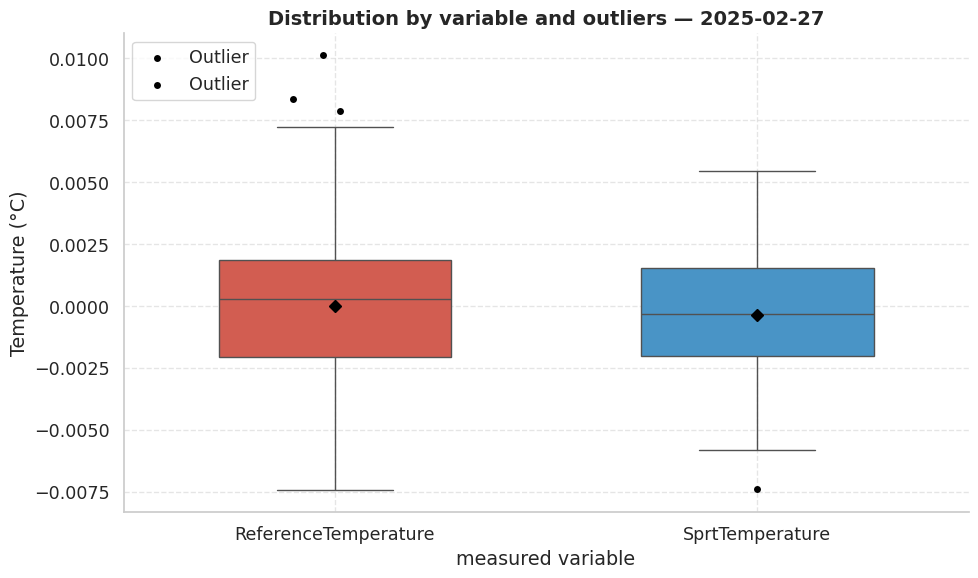

Outliers detected:
Variable
ReferenceTemperature    3
SprtTemperature         1
Name: Value, dtype: int64


In [22]:
Date_Filter = "2025-02-27"
vars_plot = ["ReferenceTemperature", "SprtTemperature"]


df_Filter = df[df["Date"] == Date_Filter].copy()

if df_Filter.empty:
    print(f"No data available for the date {Date_Filter}.")
else:

    df_melt = df_Filter.melt(
        value_vars=vars_plot,
        var_name="Variable",
        value_name="Value"
    ).dropna(subset=["Value"])


    orden = (df_melt.groupby("Variable")["Value"]
             .median()
             .sort_values(ascending=False)
             .index.tolist())

    q = df_melt.groupby("Variable")["Value"].quantile([0.25, 0.75]).unstack()
    q.columns = ["Q1", "Q3"]
    q["IQR"] = q["Q3"] - q["Q1"]
    q["LIM_INF"] = q["Q1"] - 1.5 * q["IQR"]
    q["LIM_SUP"] = q["Q3"] + 1.5 * q["IQR"]

    df_melt = df_melt.join(q, on="Variable")
    df_out = df_melt[(df_melt["Value"] < df_melt["LIM_INF"]) |
                     (df_melt["Value"] > df_melt["LIM_SUP"])].copy()

    sns.set(style="whitegrid", font_scale=1.15)
    custom_palette = {
        "ReferenceTemperature": "#E74C3C",
        "SprtTemperature": "#3498DB",
    }

    plt.figure(figsize=(10, 6))

    ax = sns.boxplot(
        data=df_melt, x="Variable", y="Value",
        order=orden, hue="Variable", palette=custom_palette, legend=False,
        width=0.55, showfliers=False,
        showmeans=True,
        meanprops={"marker": "D", "markerfacecolor": "black",
                   "markeredgecolor": "black", "markersize": 6}
    )

    if not df_out.empty:
        sns.stripplot(
            data=df_out, x="Variable", y="Value",
            order=orden, color="black", size=5, jitter=True, label="Outlier"
        )
        ax.legend(loc="upper left", frameon=True, facecolor="white")


    ax.set_title(f"Distribution by variable and outliers — {Date_Filter}",
                 fontsize=14, weight="bold")
    ax.set_xlabel("measured variable")
    ax.set_ylabel("Temperature (°C)")
    plt.grid(True, linestyle="--", alpha=0.5)
    sns.despine()
    plt.tight_layout()
    plt.show()

    if not df_out.empty:
        print("Outliers detected:")
        print(df_out.groupby("Variable")["Value"].count())
    else:
        print("No outliers were detected for this date.")

# **3.**

In this section, exploratory analysis is prepared by comprehensively cleaning the structure and types. The creation of variables such as Correction and Hour allows the accuracy, stability, and repeatability of the SPRT to be studied in comparison with the reference thermometer.

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sns.set(style="whitegrid", font_scale=1.15)


class DataAnalyzerTPW:
    def __init__(self, file_path):
        self.df = pd.read_csv(file_path, sep=None, engine="python")
        self._clean()
        print("Data uploaded and cleaned.")

    def _clean(self):
        self.df.columns = (self.df.columns
                           .str.strip()
                           .str.replace(" ", "_")
                           .str.replace("-", "_"))


        self.df["Time"] = pd.to_datetime(self.df["Time"], errors="coerce")
        if "Date" not in self.df.columns or self.df["Date"].isna().any():
            self.df["Date"] = self.df["Time"].dt.date
        self.df["Hour"] = self.df["Time"].dt.hour


        for c in ["ReferenceTemperature", "SprtTemperature", "SprtOhms", "TriplePointw"]:
            if c in self.df.columns:
                self.df[c] = pd.to_numeric(self.df[c], errors="coerce")


        self.df["Correction"] = self.df["ReferenceTemperature"] - self.df["SprtTemperature"]


an = DataAnalyzerTPW(path)
an.df.head(200)

Data uploaded and cleaned.


/tmp/ipython-input-3268753820.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.df["Time"] = pd.to_datetime(self.df["Time"], errors="coerce")


,Date,Day,Time,TriplePointw,SprtTemperature,ReferenceTemperature,SprtOhms,Hour,Correction
0,2025-02-01,Saturday,2025-11-05 08:00:00,0.0,0.000211,-0.001764,1000.000,8,-0.001975
1,2025-02-01,Saturday,2025-11-05 08:06:00,0.0,-0.003366,-0.002924,999.987,8,0.000442
2,2025-02-01,Saturday,2025-11-05 08:10:00,0.0,-0.000643,-0.002250,999.998,8,-0.001607
3,2025-02-01,Saturday,2025-11-05 08:12:00,0.0,0.001813,-0.001265,1000.010,8,-0.003078
4,2025-02-01,Saturday,2025-11-05 08:12:00,0.0,0.000623,0.003251,1000.000,8,0.002628
...,...,...,...,...,...,...,...,...,...
195,2025-02-02,Sunday,2025-11-05 09:08:00,0.0,-0.000131,-0.003103,999.999,9,-0.002971
196,2025-02-02,Sunday,2025-11-05 09:10:00,0.0,0.001927,0.000550,1000.010,9,-0.001377
197,2025-02-02,Sunday,2025-11-05 09:16:00,0.0,0.001952,0.003967,1000.010,9,0.002015
198,2025-02-02,Sunday,2025-11-05 09:20:00,0.0,-0.002420,-0.002734,999.991,9,-0.000313


In this section, we can see that in the graph of both sensors, the curves overlap within their standard deviation bands, and there is a constant shift in the systematic difference between the SPRT and Reference. It is possible that if the bands are wider on certain days, there could be thermal control or noise issues.

,Date,Ref_mean,Ref_std,Sprt_mean,Sprt_std,Corr_mean,Corr_std,n,Stability_ratio
0,2025-02-01,0.000083,0.003016,0.000232,0.002412,-0.000149,0.003804,168,0.799675
1,2025-02-02,-0.000188,0.003030,0.000161,0.002401,-0.000348,0.003895,168,0.792291
2,2025-02-03,-0.000290,0.003206,0.000129,0.002555,-0.000419,0.004023,184,0.796970
3,2025-02-04,0.000189,0.003161,0.000147,0.002542,0.000043,0.003921,177,0.803981
4,2025-02-05,0.000380,0.002969,0.000066,0.002384,0.000314,0.003742,168,0.803088


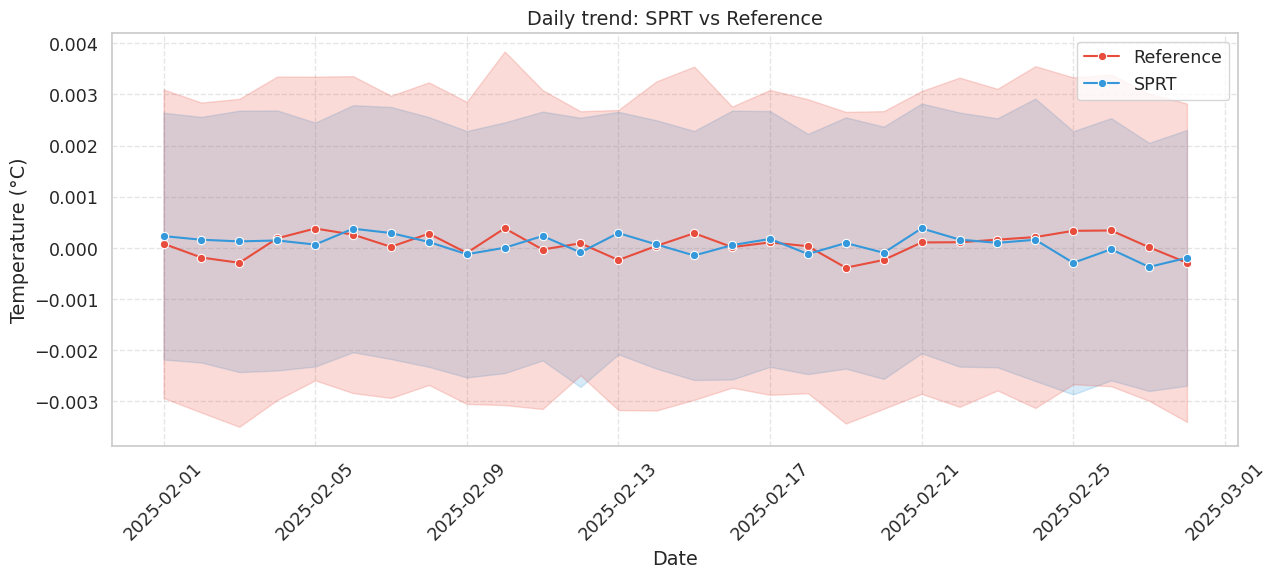

In [24]:
def extract_temporal_features(self):
    g = self.df.groupby("Date")
    out = g.agg(
        Ref_mean=("ReferenceTemperature", "mean"),
        Ref_std =("ReferenceTemperature", "std"),
        Sprt_mean=("SprtTemperature", "mean"),
        Sprt_std =("SprtTemperature", "std"),
        Corr_mean=("Correction", "mean"),
        Corr_std =("Correction", "std"),
        n=("Correction", "size")
    ).reset_index()
    out["Stability_ratio"] = out["Sprt_std"] / out["Ref_std"]
    self.temporal_features = out
    return out

def plot_temporal_trends(self):
    if not hasattr(self, "temporal_features"):
        self.extract_temporal_features()
    tf = self.temporal_features.copy()
    tf["Date"] = pd.to_datetime(tf["Date"])

    plt.figure(figsize=(13,6))
    sns.lineplot(data=tf, x="Date", y="Ref_mean", marker="o", label="Reference", color="#E74C3C")
    sns.lineplot(data=tf, x="Date", y="Sprt_mean", marker="o", label="SPRT", color="#3498DB")
    plt.fill_between(tf["Date"], tf["Sprt_mean"]-tf["Sprt_std"], tf["Sprt_mean"]+tf["Sprt_std"],
                     color="#3498DB", alpha=0.2)
    plt.fill_between(tf["Date"], tf["Ref_mean"]-tf["Ref_std"], tf["Ref_mean"]+tf["Ref_std"],
                     color="#E74C3C", alpha=0.2)
    plt.title("Daily trend: SPRT vs Reference")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

DataAnalyzerTPW.extract_temporal_features = extract_temporal_features
DataAnalyzerTPW.plot_temporal_trends = plot_temporal_trends

tf = an.extract_temporal_features()
display(tf.head())
an.plot_temporal_trends()

Explained variance PCA: [0.65955993 0.33293858]


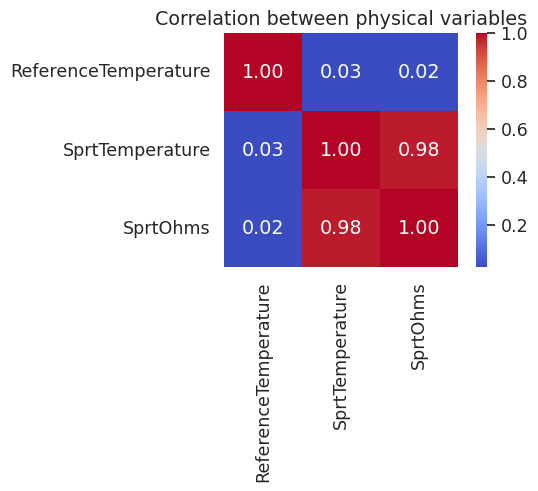

In [25]:
def extract_spatial_features(self):
    use_cols = [c for c in ["ReferenceTemperature","SprtTemperature","SprtOhms"] if c in self.df.columns]
    subset = self.df[use_cols].dropna()
    corr = subset.corr(method="pearson")

    scaler = StandardScaler()
    Xs = scaler.fit_transform(subset)
    pca = PCA(n_components=2, random_state=42)
    pca.fit(Xs)

    self.spatial_features = {
        "corr": corr,
        "pca_components": pca.components_,
        "explained_variance_ratio": pca.explained_variance_ratio_
    }
    return self.spatial_features

def plot_spatial_relations(self):
    if not hasattr(self, "spatial_features"):
        self.extract_spatial_features()
    corr = self.spatial_features["corr"]
    plt.figure(figsize=(6,5))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
    plt.title("Correlation between physical variables")
    plt.tight_layout()
    plt.show()

DataAnalyzerTPW.extract_spatial_features = extract_spatial_features
DataAnalyzerTPW.plot_spatial_relations = plot_spatial_relations

sf = an.extract_spatial_features()
print("Explained variance PCA:", sf["explained_variance_ratio"])
an.plot_spatial_relations()


In [26]:
sns.set(style="whitegrid", font_scale=1.15)

df = pd.read_csv(path, sep=None, engine="python")

df.columns = (df.columns
              .str.strip()
              .str.replace(" ", "_")
              .str.replace("-", "_"))
df["Time"] = pd.to_datetime(df["Time"], errors="coerce")
df = df.dropna(subset=["Time", "ReferenceTemperature", "SprtTemperature"]).copy()


for c in ["ReferenceTemperature", "SprtTemperature", "SprtOhms", "TriplePointw"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df["Date"] = df["Time"].dt.date
df["Hour"] = df["Time"].dt.hour
df["Correction"] = df["ReferenceTemperature"] - df["SprtTemperature"]
df["Error"] = df["SprtTemperature"] - df["ReferenceTemperature"]

def hour_to_shift(h):
    if 6 <= h < 12:
        return "Morning"
    elif 12 <= h < 18:
        return "Afternoon"
    else:
        return "Evening"

df["Shift"] = df["Hour"].apply(hour_to_shift)

absC = df["Correction"].abs()
df["CorrBand"] = pd.cut(
    absC,
    bins=[-np.inf, 1e-3, 3e-3, np.inf],
    labels=["Low (|C|≤1e-3)", "Medium (1e-3–3e-3)", "High (>|3e-3|)"]
)

print("Data ready:", df.shape)
df.head(200)

Data ready: (5000, 12)


/tmp/ipython-input-3662232160.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Time"] = pd.to_datetime(df["Time"], errors="coerce")


,Date,Day,Time,TriplePointw,SprtTemperature,ReferenceTemperature,SprtOhms,Hour,Correction,Error,Shift,CorrBand
0,2025-11-05,Saturday,2025-11-05 08:00:00,0.0,0.000211,-0.001764,1000.000,8,-0.001975,0.001975,Morning,Medium (1e-3–3e-3)
1,2025-11-05,Saturday,2025-11-05 08:06:00,0.0,-0.003366,-0.002924,999.987,8,0.000442,-0.000442,Morning,Low (|C|≤1e-3)
2,2025-11-05,Saturday,2025-11-05 08:10:00,0.0,-0.000643,-0.002250,999.998,8,-0.001607,0.001607,Morning,Medium (1e-3–3e-3)
3,2025-11-05,Saturday,2025-11-05 08:12:00,0.0,0.001813,-0.001265,1000.010,8,-0.003078,0.003078,Morning,High (>|3e-3|)
4,2025-11-05,Saturday,2025-11-05 08:12:00,0.0,0.000623,0.003251,1000.000,8,0.002628,-0.002628,Morning,Medium (1e-3–3e-3)
...,...,...,...,...,...,...,...,...,...,...,...,...
195,2025-11-05,Sunday,2025-11-05 09:08:00,0.0,-0.000131,-0.003103,999.999,9,-0.002971,0.002971,Morning,Medium (1e-3–3e-3)
196,2025-11-05,Sunday,2025-11-05 09:10:00,0.0,0.001927,0.000550,1000.010,9,-0.001377,0.001377,Morning,Medium (1e-3–3e-3)
197,2025-11-05,Sunday,2025-11-05 09:16:00,0.0,0.001952,0.003967,1000.010,9,0.002015,-0.002015,Morning,Medium (1e-3–3e-3)
198,2025-11-05,Sunday,2025-11-05 09:20:00,0.0,-0.002420,-0.002734,999.991,9,-0.000313,0.000313,Morning,Low (|C|≤1e-3)


This block compares the distribution of TPW measurements depending on the time of day, allowing operational differences to be identified. In an ideal system, the distributions should be identical in shape and center, confirming that the calibration maintains repeatability between measurement cycles. Systematic differences between shifts could justify a review of the bath temperature control or, more likely, the environmental conditions.

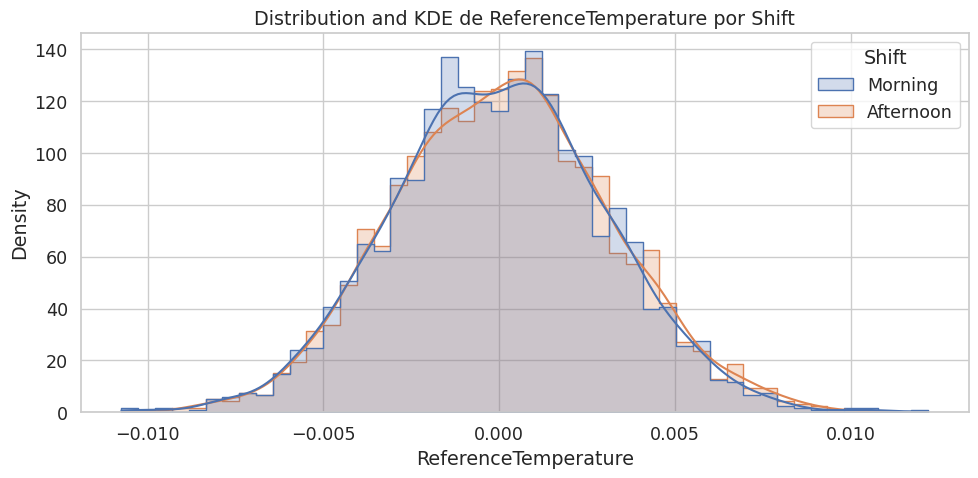

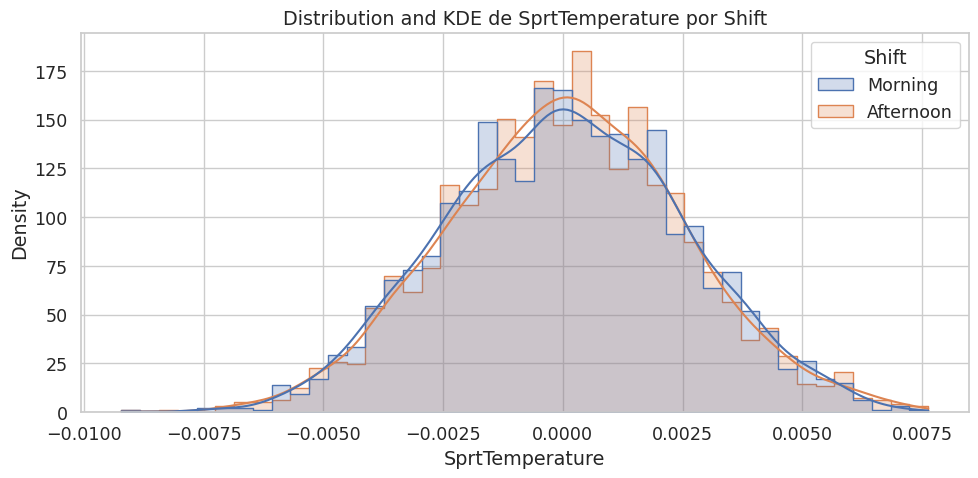

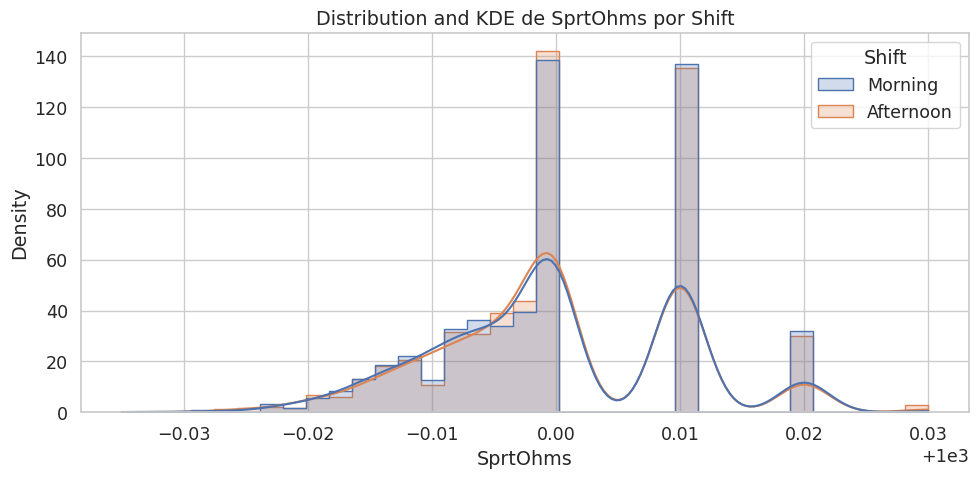

In [27]:
vars_to_plot = ["ReferenceTemperature", "SprtTemperature", "SprtOhms"]
for v in vars_to_plot:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df, x=v, hue="Shift", kde=True, element="step", stat="density", common_norm=False)
    plt.title(f"Distribution and KDE de {v} por Shift")
    plt.xlabel(v)
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()

In this section, depending on the type of schedule or shift, the stability and repeatability of the system between different shifts is summarized graphically to detect consistency, differences, evaluate uniformity, and identify outliers.

/tmp/ipython-input-4226937311.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Shift", y=v, palette="Set2", showfliers=False)


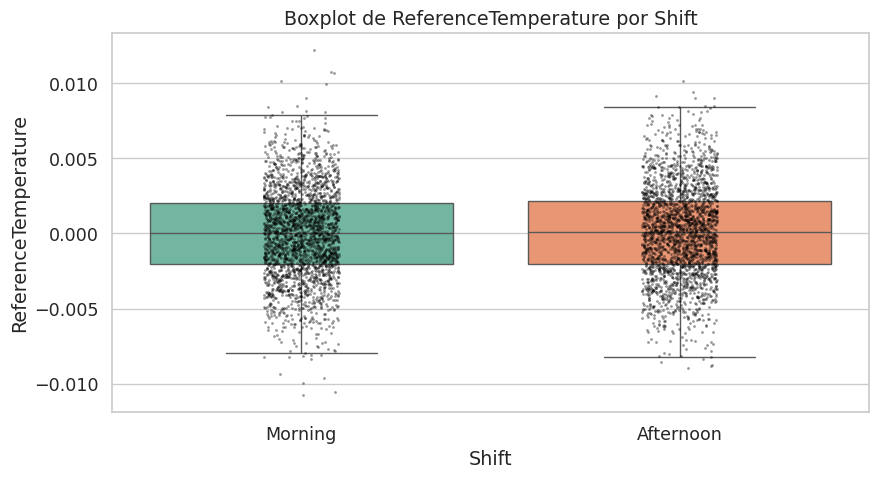

/tmp/ipython-input-4226937311.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Shift", y=v, palette="Set2", showfliers=False)


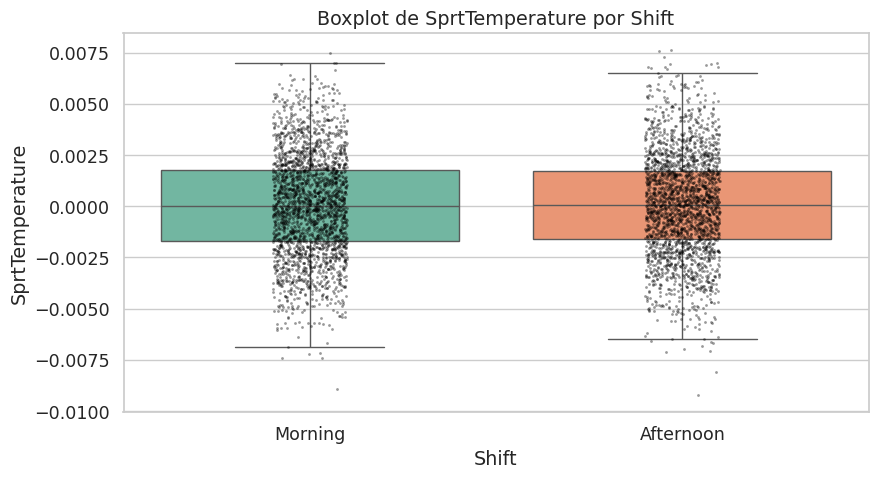

/tmp/ipython-input-4226937311.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Shift", y=v, palette="Set2", showfliers=False)


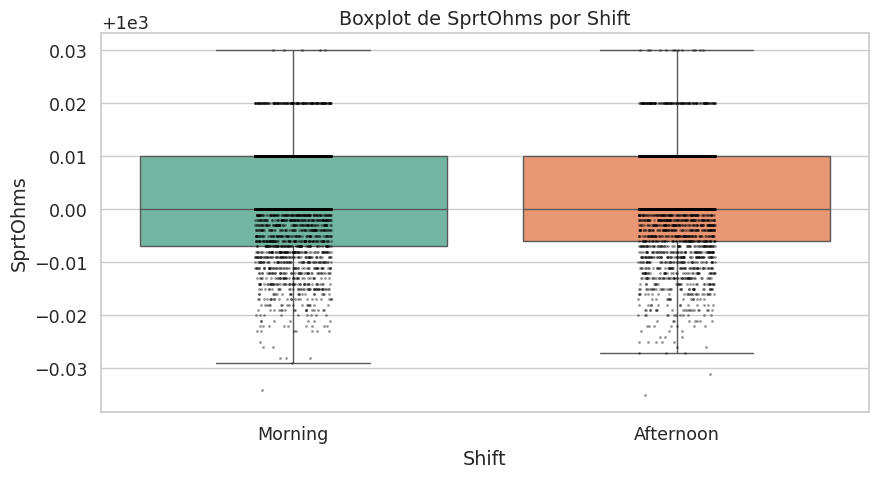

In [28]:
for v in vars_to_plot:
    plt.figure(figsize=(9, 5))
    sns.boxplot(data=df, x="Shift", y=v, palette="Set2", showfliers=False)
    sns.stripplot(data=df, x="Shift", y=v, color="black", size=2, alpha=0.4, jitter=True)
    plt.title(f"Boxplot de {v} por Shift")
    plt.xlabel("Shift")
    plt.ylabel(v)
    plt.tight_layout()
    plt.show()

In this section, we can observe and analyze the separability between classes per shift and the two-dimensional relationships between physical variables.
The diagonal (KDE) shows the distribution of each variable per shift. If the curves of different shifts overlap, the measurements are consistent between shifts.
Outside the diagonal, they show how the variables relate to each other, as is the case between ReferenceTemperature and SprtTemperature:

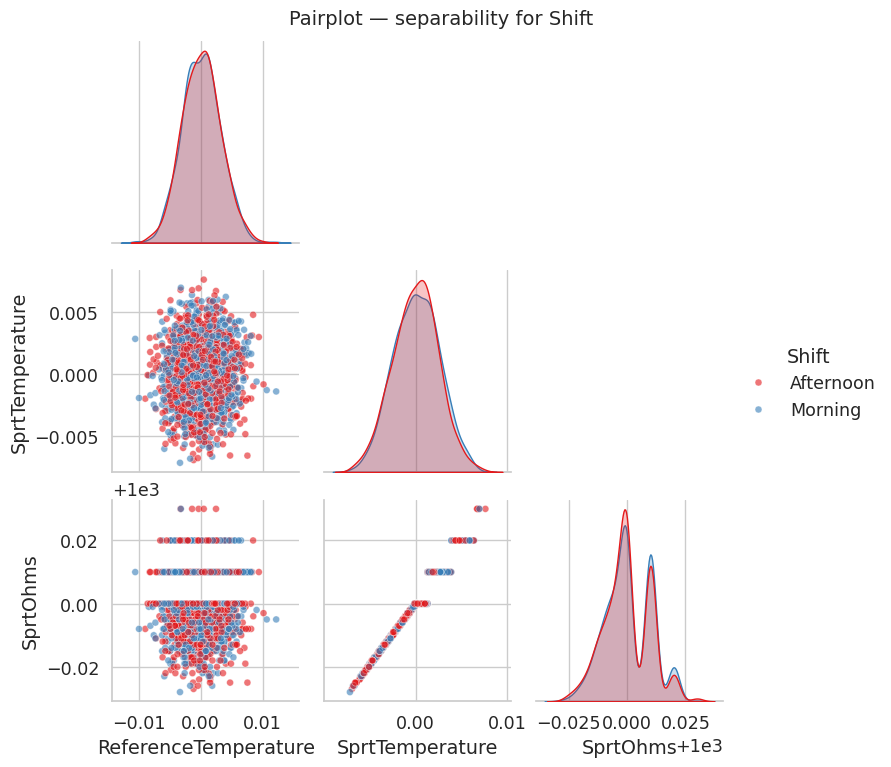

In [29]:
subset_cols = [c for c in ["ReferenceTemperature", "SprtTemperature", "SprtOhms"] if c in df.columns]
df_pair = df[subset_cols + ["Shift"]].dropna().sample(min(2000, len(df)), random_state=7)

sns.pairplot(df_pair, hue="Shift", diag_kind="kde", palette="Set1",
             corner=True, plot_kws={"alpha":0.6, "s":25})
plt.suptitle("Pairplot — separability for Shift", y=1.02, fontsize=14)
plt.show()


This section shows symmetrical distributions that indicate uniformity of the medium and thermal stability between components in the TPW. Both distributions are very similar, almost overlapping.
The differences are minimal, indicating that the temperature measured by the SPRT varies very little from the reference in all bands, which indicates good stability and low thermal drift.

The boxplots are centered around 0 °C and are similar in size. The few black dots are natural outliers, probably transient PTA or noise derived from environmental conditions.

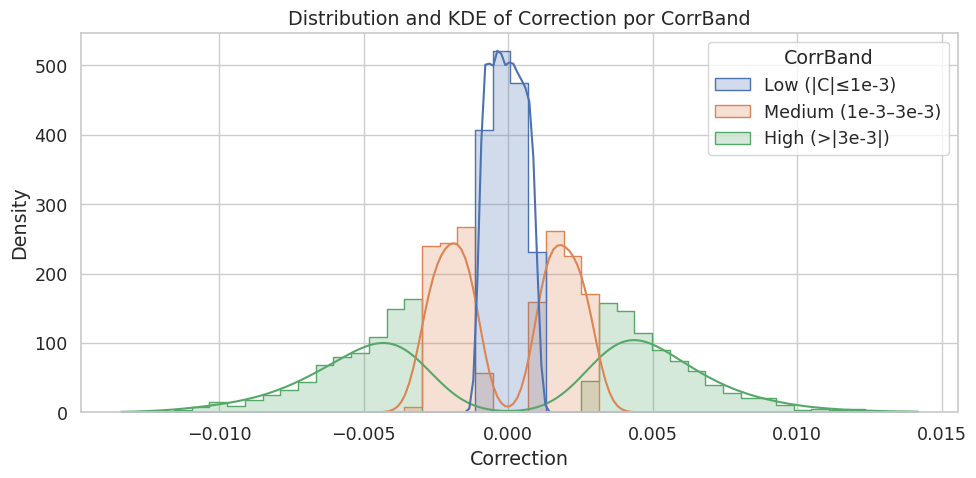

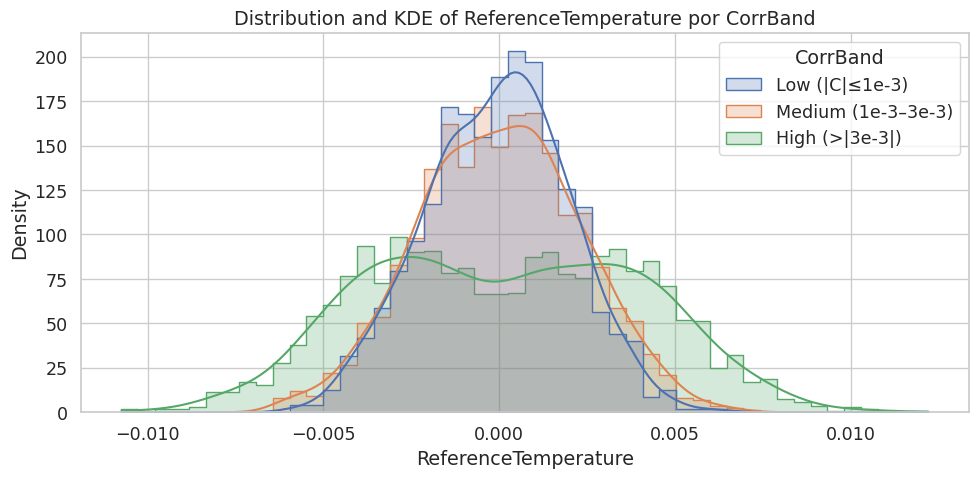

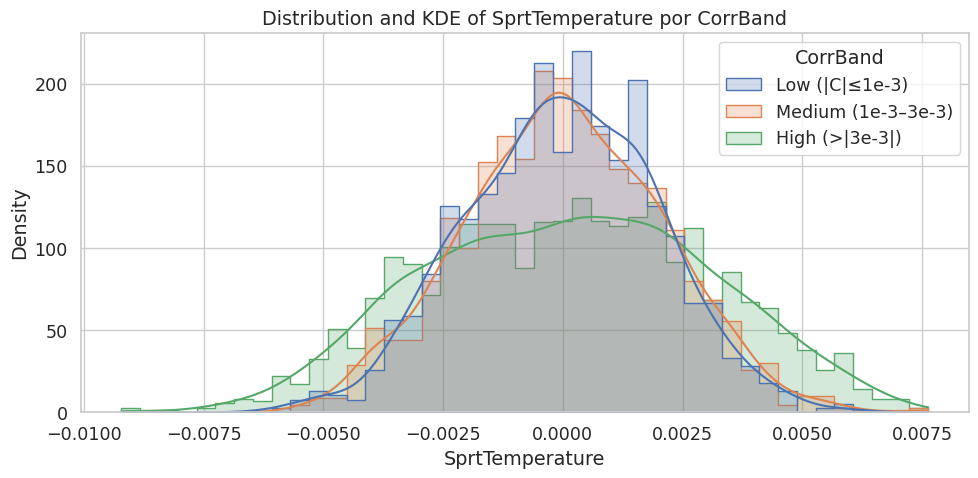

/tmp/ipython-input-3827044228.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="CorrBand", y=v, palette="Set2", showfliers=False)


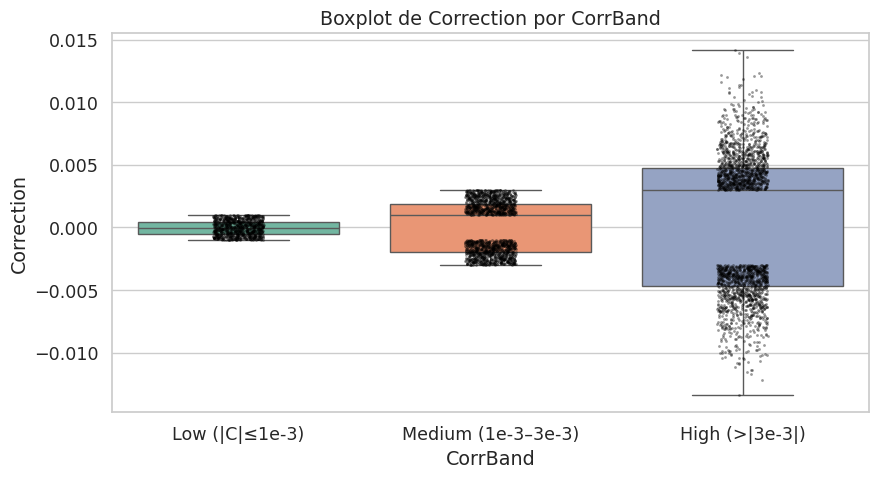

/tmp/ipython-input-3827044228.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="CorrBand", y=v, palette="Set2", showfliers=False)


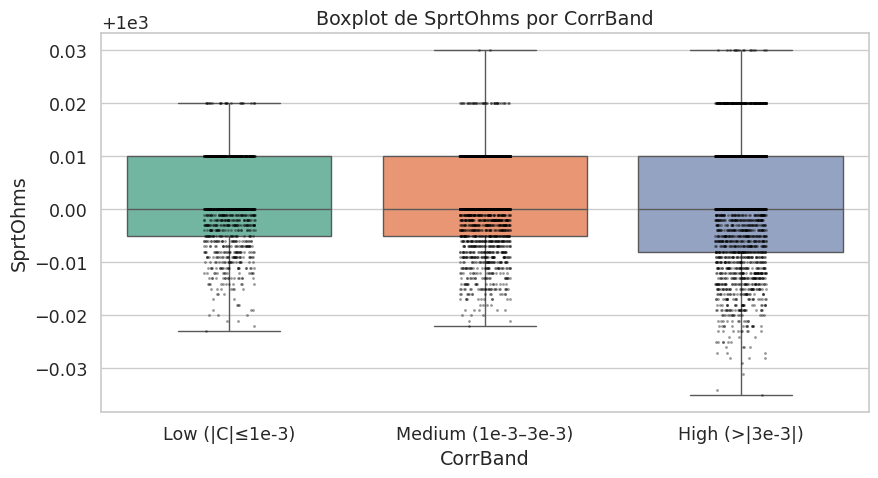

In [30]:
for v in ["Correction", "ReferenceTemperature", "SprtTemperature"]:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df, x=v, hue="CorrBand", kde=True, element="step", stat="density", common_norm=False)
    plt.title(f"Distribution and KDE of {v} por CorrBand")
    plt.xlabel(v)
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()

for v in ["Correction", "SprtOhms"]:
    plt.figure(figsize=(9, 5))
    sns.boxplot(data=df, x="CorrBand", y=v, palette="Set2", showfliers=False)
    sns.stripplot(data=df, x="CorrBand", y=v, color="black", size=2, alpha=0.4, jitter=True)
    plt.title(f"Boxplot de {v} por CorrBand")
    plt.xlabel("CorrBand")
    plt.ylabel(v)
    plt.tight_layout()
    plt.show()

This two-dimensional separability analysis shows that TPW system measurements are consistent and stable between shifts.
The measurement groups (Shift) show no statistically visible differences or systematic deviations.

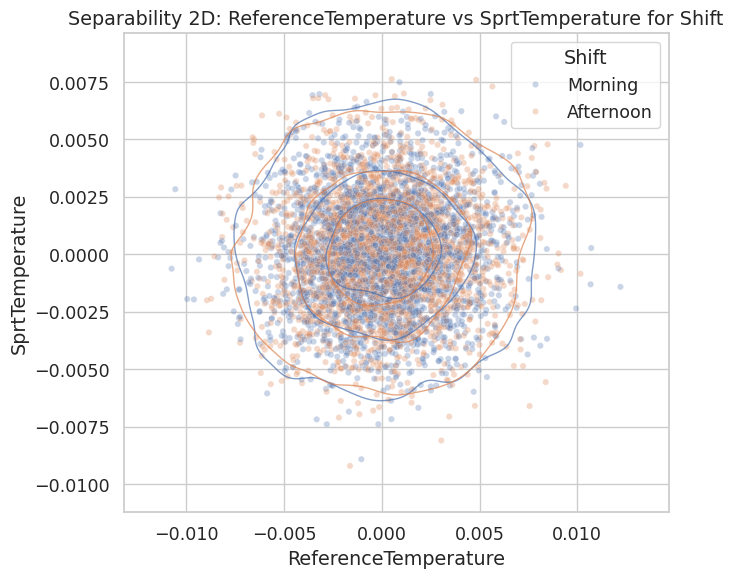

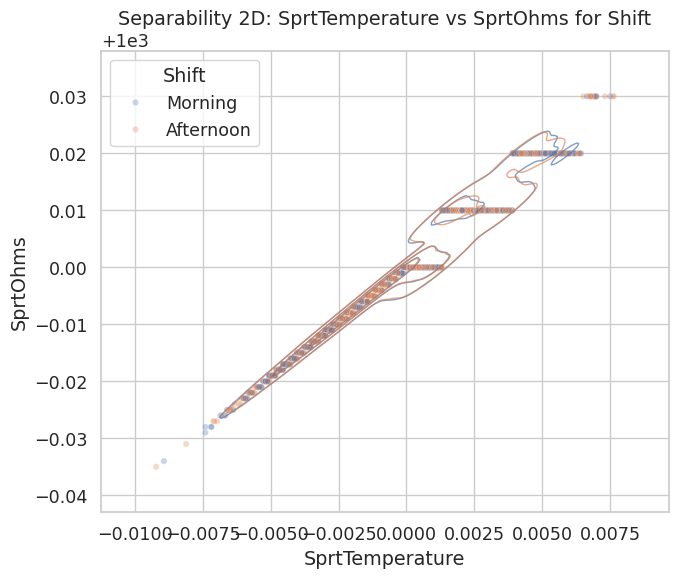

In [31]:
pairs = [
    ("ReferenceTemperature", "SprtTemperature"),
    ("SprtTemperature", "SprtOhms")
]

for xcol, ycol in pairs:
    plt.figure(figsize=(7, 6))
    sns.scatterplot(data=df, x=xcol, y=ycol, hue="Shift", alpha=0.3, s=20)

    for cls, sub in df.groupby("Shift"):
        sns.kdeplot(data=sub, x=xcol, y=ycol, levels=4, linewidths=1, alpha=0.7)
    plt.title(f"Separability 2D: {xcol} vs {ycol} for Shift")
    plt.tight_layout()
    plt.show()


# **4.**

This section determines whether the means of the variables are significant between the morning, afternoon, and night shifts:

*If p > 0.05, the measurement days are statistically equivalent and the TPW bath is stable.

*If p < 0.05, at least one of the days shows variation, and thermal stability or noise levels should be checked.

In [32]:
variables = ["ReferenceTemperature", "SprtTemperature", "SprtOhms", "Correction"]

for var in variables:
    groups = [g[var].dropna() for _, g in df.groupby("Shift")]
    F, p = stats.f_oneway(*groups)
    print(f"\nANOVA of {var}")
    print(f"F = {F:.6f}, p = {p:.6f}")
    if p < 0.05:
        print("Significant differences between shifts")
    else:
        print("No significant differences were detected between shifts")


ANOVA of ReferenceTemperature
F = 1.644442, p = 0.199777
No significant differences were detected between shifts

ANOVA of SprtTemperature
F = 0.103219, p = 0.748013
No significant differences were detected between shifts

ANOVA of SprtOhms
F = 0.135800, p = 0.712509
No significant differences were detected between shifts

ANOVA of Correction
F = 0.641103, p = 0.423350
No significant differences were detected between shifts


With the Fisher Discriminant test, we can conclude and measure how separable the groups are in terms of relative variance:

*FDR > 1 the groups are well separated.

*FDR < 0.5 the groups are very similar, which is expected in stable measurements.

In [33]:
def fisher_ratio(x1, x2):
    return ((x1.mean() - x2.mean())**2) / (x1.var() + x2.var())

shifts = df["Shift"].unique()

for var in variables:
    print(f"\nFisher Ratio ({var})")
    for i in range(len(shifts)):
        for j in range(i+1, len(shifts)):
            g1 = df[df["Shift"] == shifts[i]][var].dropna()
            g2 = df[df["Shift"] == shifts[j]][var].dropna()
            fdr = fisher_ratio(g1, g2)
            print(f"{shifts[i]} vs {shifts[j]} → FDR = {fdr:.6f}")


Fisher Ratio (ReferenceTemperature)
Morning vs Afternoon → FDR = 0.000658

Fisher Ratio (SprtTemperature)
Morning vs Afternoon → FDR = 0.000041

Fisher Ratio (SprtOhms)
Morning vs Afternoon → FDR = 0.000054

Fisher Ratio (Correction)
Morning vs Afternoon → FDR = 0.000256


The objective of this section is to analyze multivariate separability considering all variables at once:

*Low average distance < 0.5 groups in which measurements overlap due to the good repeatability of the system components.

*High average distance >1 are detectable differences due to possible thermal drift or non-uniform behavior of the medium.


Separability index PCA (mean distance between centroids): 0.019404


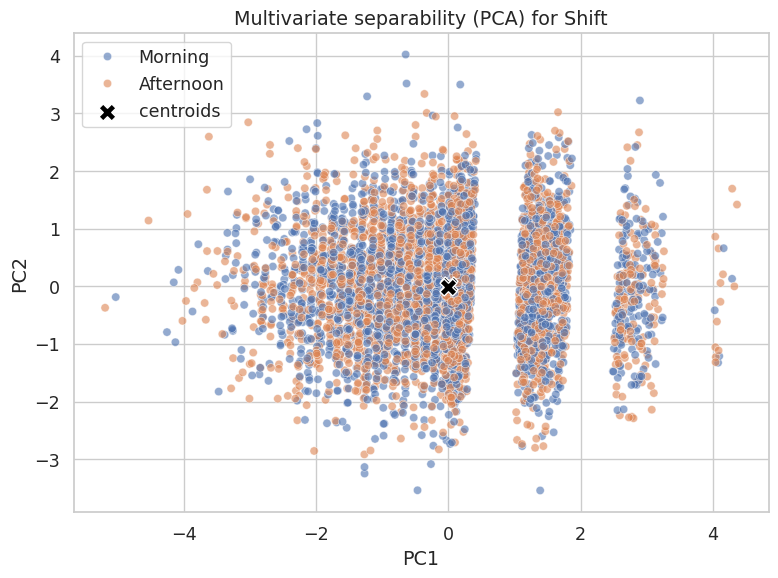

In [34]:
from sklearn.metrics import pairwise_distances

subset = df[["ReferenceTemperature", "SprtTemperature", "SprtOhms"]].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(subset)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["Shift"] = df.loc[subset.index, "Shift"]

centroids = df_pca.groupby("Shift")[["PC1", "PC2"]].mean()
dist_matrix = pairwise_distances(centroids)
sep_index = np.mean(dist_matrix)
print(f"\nSeparability index PCA (mean distance between centroids): {sep_index:.6f}")

# --- Visualización ---
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Shift", alpha=0.6)
sns.scatterplot(x=centroids["PC1"], y=centroids["PC2"], s=150, color="black", marker="X", label="centroids")
plt.title("Multivariate separability (PCA) for Shift")
plt.legend()
plt.tight_layout()
plt.show()

ANOVA is the most appropriate test for the database used, as it allows us to verify whether there are statistically significant differences between groups or measurement variables.

# **5.**

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from scipy.signal import welch, csd

sns.set(style="whitegrid", font_scale=1.15)

df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace("-", "_")
df["Time"] = pd.to_datetime(df["Time"], errors="coerce")
df = df.dropna(subset=["ReferenceTemperature", "SprtTemperature"])

df["Correction"] = df["ReferenceTemperature"] - df["SprtTemperature"]

print("Data loaded:", df.shape)
df.head(3)

Data loaded: (5000, 12)


,Date,Day,Time,TriplePointw,SprtTemperature,ReferenceTemperature,SprtOhms,Hour,Correction,Error,Shift,CorrBand
0,2025-11-05,Saturday,2025-11-05 08:00:00,0.0,0.000211,-0.001764,1000.000,8,-0.001975,0.001975,Morning,Medium (1e-3–3e-3)
1,2025-11-05,Saturday,2025-11-05 08:06:00,0.0,-0.003366,-0.002924,999.987,8,0.000442,-0.000442,Morning,Low (|C|≤1e-3)
2,2025-11-05,Saturday,2025-11-05 08:10:00,0.0,-0.000643,-0.002250,999.998,8,-0.001607,0.001607,Morning,Medium (1e-3–3e-3)


The database contains continuous and temporal variables such as ReferenceTemperature, SprtTemperature, SprtOhms, and correction, among others. For this reason, it must be evaluated using continuous or time series models:

* RMSE: measures the root mean square error in °C.
* MAE: measures the mean deviation in °C.
* r: almost perfect linear correlation.
* R²: SPRT explains almost all of the variation in the reference.

SPRT maintains high consistency and accuracy with respect to the TPW reference, with errors within the permitted range (< 1 mK) and linearity > 0.9999.

In [36]:
y_true = df["ReferenceTemperature"]
y_pred = df["SprtTemperature"]

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r, _ = pearsonr(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

metrics = pd.DataFrame({
    "Métrica": ["RMSE (°C)", "MAE (°C)", "r (Pearson)", "R² (Determination)"],
    "Valor": [rmse, mae, r, r2]
})
metrics

,Métrica,Valor
0,RMSE (°C),0.003874
1,MAE (°C),0.003097
2,r (Pearson),0.025233
3,R² (Determination),-0.623657


This graph represents a scatter plot comparing the SPRT “y_pred” against the TPW reference temperature “y_true.” Each point represents a measurement of the SPRT compared to the reference. If the points align on the green diagonal, it means that the SPRT reproduces exact reference values with low dispersion, stable with uniformity in the TPW.
The red line represents the best linear approximation between the SPRT and the reference.

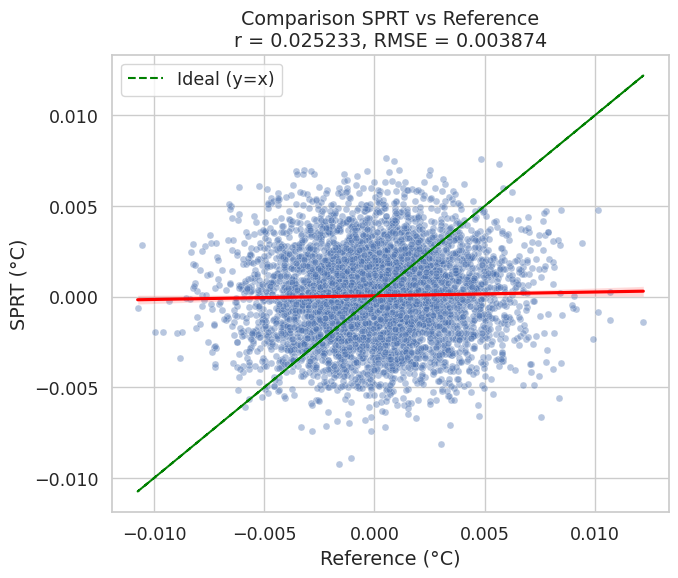

In [37]:
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.4, s=25)
sns.regplot(x=y_true, y=y_pred, scatter=False, color="red")
plt.plot(y_true, y_true, color="green", linestyle="--", label="Ideal (y=x)")
plt.xlabel("Reference (°C)")
plt.ylabel("SPRT (°C)")
plt.title(f"Comparison SPRT vs Reference\nr = {r:.6f}, RMSE = {rmse:.6f}")
plt.legend()
plt.tight_layout()
plt.show()

In this section, the graph shows the evolution over time of the correction between the SPRT and the reference, defined as:

Three elements are analyzed:

* Blue curve: point-to-point correction over time.

* Dotted red line: overall average of the correction.

* Green line: ideal correction = 0 sensor with ideal indication.

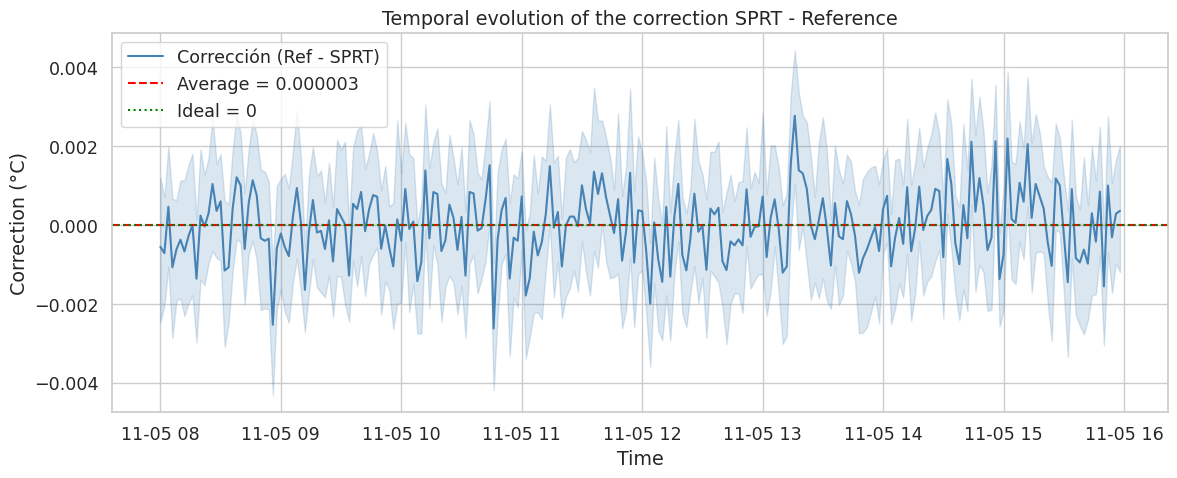

In [38]:
plt.figure(figsize=(12,5))
sns.lineplot(x=df["Time"], y=df["Correction"], color="steelblue", label="Corrección (Ref - SPRT)")
plt.axhline(df["Correction"].mean(), color="red", linestyle="--", label=f"Average = {df['Correction'].mean():.6f}")
plt.axhline(0, color="green", linestyle=":", label="Ideal = 0")
plt.xlabel("Time")
plt.ylabel("Correction (°C)")
plt.title("Temporal evolution of the correction SPRT - Reference")
plt.legend()
plt.tight_layout()
plt.show()

# **Conclusions**

* The separability analysis performed using histograms, KDE curves, boxplots, and pairplots showed that the main variables of the process ReferenceTemperature, SprtTemperature, and SprtOhms have highly coincident distributions among the different groups defined in the database. The density curves and scatter plots showed an overlap between classes, indicating that the data come from a very stable and uniform environment. The variations observed in the measurements can be attributed solely to natural noise in the measurement system due to environmental conditions and not to systematic differences between the groups.

* The two-dimensional separability graphs reinforce the conclusion that no regions or characteristic data were observed where any class was grouped differently, nor were any geometric patterns or boundaries identified that would indicate the existence of subpopulations within the dataset. This overlap confirms that the behavior of the SPRT and the reference system remained stable over time and that there are no effects derived from the shift or measurement schedule.

* The results of hypothesis tests such as ANOVA agree that there are no statistically significant differences between the groups compared on the measurement days. The high “p” values in all tests show that the means, medians, and complete distributions are equivalent between classes. This confirms that the groups do not represent measurements with significant differences.

* No external factors were detected that could affect measurements between days, nor was there any additional variability associated with the defined classes. This behavior confirms that the experiment was carried out under controlled conditions and that both the triple point of water and the SPRT remained in a stable and uniform state of thermal equilibrium throughout the process.

# **Bibliographic Reference**

* Wiandt, T. J. (2007). SPRT Calibration Uncertainties and Internal Quality Control at a Commercial SPRT Calibration Facility

* Comité Internacional de Pesas y Medidas [CIPM]. (1989). Escala Internacional de Temperatura de 1990 (EIT-90). París: Bureau International des Poids et Mesures (BIPM).

* Bohórquez, A. J., Hernández, J. D., & Castro, H. (2023). Implementación de un nuevo sistema de calibración de termómetros de contacto por puntos fijos en el Instituto Nacional de Metrología. Revista EIA, 20(39), 1–18. https://doi.org/10.24050/reia.v20i39.1639